In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# main constants

# reference distance (meters)
d0 = 1 
# constant for particular propagation enviroment
k = 1e-4
# path loss exponent
n = 4
# total available bandwidth (Hz)
b_t = 100 * 1e6
# constant for noise power (W/Hz)
k_0 = 1e-20
# Side of total area (meters)
area_side = 1e3

In [3]:
def lin2db(x):
    return 10.0*np.log10(x)

def db2lin(x):
    return 10.0**(x/10.0)

def lin2dbm(x):
    return 10.0*np.log10(x)+30.0

def dbm2lin(x):
    return 10.0**(x/10.0 - 3.0)

In [4]:
def random_position():
    
    x_position = np.random.rand()*area_side
    y_position = np.random.rand()*area_side
    
    return [x_position, y_position]

def distance(UE_position, AP_position):

    distance_calculated =  np.linalg.norm(np.array(UE_position)
                                          - np.array(AP_position))

    return distance_calculated
    
def AP_position(AP_quantity):
    
    # Generates a list of coordenates according to the number of APs
    # in the simulation. It distributes the APs evenly.

    # Checks if the number of APs is a perfect square.
    if np.sqrt(AP_quantity).is_integer(): 

        AP_quantity_side = int(np.sqrt(AP_quantity))
    
        cell_side = area_side // AP_quantity_side
    
        # Creates coordenates using meshgrid.
        x, y = np.meshgrid(np.arange(0.5 * cell_side, 
                                     area_side, 
                                     cell_side),
                           np.arange(0.5 * cell_side, 
                                     area_side, 
                                     cell_side))
        
        APs_positions = np.column_stack((x.ravel(), y.ravel()))
    else:
        print("AP quantity must be a perfect square")

    return APs_positions

In [5]:
# Functions to calculate equations given by the base material

def calculate_received_power(transmitted_power, shadowing, distance):
    return transmitted_power * shadowing * (k / (distance**n))
    
def calculate_bandwidth_channel(total_bandwidth, channels_quantity):
    return total_bandwidth / channels_quantity

def calculate_noise_power(total_bandwidth, channels_quantity):
    return k_0 * calculate_bandwidth_channel(total_bandwidth, channels_quantity)

def calculate_SNR(user_power, noise_power):
    return user_power / noise_power

def calculate_SINR(user_power, interference_power, noise_power):
    return user_power / (interference_power + noise_power)

In [6]:
def eCDF(data):
    x = np.sort(data)
    y = np.arange(0, len(data)) / len(data)

    return x, y  

In [7]:
# Models the UEs
class UserEquipment:
    
    def __init__(self, transmitted_power_ = 0.25): # UE transmission power is 1 W by standard
        
        # Distance is sorted randomly in a 1000x1000m area 
        self.position = random_position()
        self.distance2AP = 0
        
        self.transmitted_power = transmitted_power_
        self.received_power = 0

        self.linkedAP = 0

In [8]:
# Models the APs
class AccessPoint:

    def __init__(self, channels_quantity_, position_ = [0, 0]):

        self.position = position_

        # Adds keys with a empty list for each channel in the system
        # self.channels = dict()
        # for m in range(channels_quantity_):
        #     self.channels[m + 1] = []

In [27]:
# CLass that plots the APs and UEs
class LinkSystem:

    '''
    for fractional power control, power_control = 0
    for max rate, power_control = 1
    '''
    def __init__(self, AP_quantity_, 
                       UE_quantity_, 
                       channels_quantity_,
                       power_control,
                       max_power_ = 0.25):

        self.AP_quantity = AP_quantity_
        self.AP_list = []
        
        self.UE_quantity = UE_quantity_
        self.UE_list = []
        
        self.channels_quantity = channels_quantity_

        self.noise_power = calculate_noise_power(b_t, 
                                                 self.channels_quantity)

        self.max_power = max_power_

        self.channels = dict()
        for m in range(channels_quantity_):
            
            self.channels[m + 1] = []
        
        ''' Matrix of shadowing of each link, in which the rows are related to UEs
        and columns are related to APs '''
        self.shadowing_matrix = np.zeros((self.UE_quantity, 
                                          self.AP_quantity))

        # The shadowing is a zero-mean lognormal distributed random variable with
        # standard deviation 2.0
        for UE in range(self.UE_quantity):
            
            for AP in range(self.AP_quantity):
                
                self.shadowing_matrix[UE][AP] = np.random.lognormal(sigma=2.0)  

        
        ''' Add APs in system '''

        # Generates the APs positions according to the AP quantity
        # in order to have evenly distributed positions
        positions = AP_position(self.AP_quantity)
        index = 0
        
        for AP in range(self.AP_quantity):
            
            self.AP_list.append(AccessPoint(self.channels_quantity, 
                                            positions[index]))
            index += 1


        ''' add UEs to the system '''
        for UE in range(self.UE_quantity):
            
                self.UE_list.append(UserEquipment())  

        
        ''' Matrix of shadowing of each link, in which the rows are related to UEs
        and columns are related to APs '''
        self.gain_matrix = np.zeros((self.UE_quantity,
                                     self.AP_quantity))
        
        # The gain is calculated as the product between the shadowing and the path loss      
        for UE in range(self.UE_quantity):
            
            for AP in range(self.AP_quantity):
                
                gain = ((self.shadowing_matrix[UE][AP] * k) 
                         / distance(self.UE_list[UE].position, self.AP_list[AP].position)**n)
                
                self.gain_matrix[UE][AP] = gain
        
        ''' Stores the linked AP from each UE according to channel
        and allocate them in this AP channels '''            
        
        self.power_sum = 0

        for UE in range(self.UE_quantity):

            bestAP = 0
            min_gain = float('-inf')
            
            for AP in range(self.AP_quantity):
                if self.gain_matrix[UE][AP] > min_gain:
                    bestAP = self.AP_list[AP]
                    min_gain = self.gain_matrix[UE][AP]
                    
            self.UE_list[UE].linkedAP = bestAP
            
            ''' Uses the AP with better channel, that it stored in the loop above.
            Stores the better channel AP from each UE and allocate them in 
            this AP channels, calculating its distance to linked AP. '''

            if self.channels_quantity > 1:
                self.channels[np.random.randint(1, self.channels_quantity)].append(self.UE_list[UE])
            else:
                self.channels[1].append(self.UE_list[UE])

            if distance(self.UE_list[UE].position, 
                        self.UE_list[UE].linkedAP.position) > d0:
                
                self.UE_list[UE].distance2AP = distance(self.UE_list[UE].position, 
                                                        self.UE_list[UE].linkedAP.position)
            else:
                self.UE_list[UE].distance2AP = d0

        
        for channel in self.channels:
            
            for UE in self.channels[channel]:
                # Calculates the received power of each UE
                each_power_sum = 0
                for AP in self.AP_list:
                    
                    each_power_sum += calculate_received_power(UE.transmitted_power, 
                                                               self.shadowing_matrix[self.UE_list.index(UE), 
                                                                                     self.AP_list.index(AP)],
                                                               distance(UE.position,
                                                                        AP.position))
                UE.received_power = each_power_sum

                
            self.power_sum += each_power_sum
        
        ''' 
        Makes the power control
        
        Fractional Power Control: Sets the power as the minimum value between the maximum power and the formula given
        by the article.

        Max Power: All users transmit with the maximum power.
        '''
        if power_control == 0:

            max_power = self.max_power # Maximum achievable power in watts
            compensation_factor = 0.6 # Compensation factor as given by article (debatable)
            target_received_power = dbm2lin(-20) # P_0 = -35 dBm
           
            self.power_list = []
       
            for i in range(self.UE_quantity):

                # zeta as defined in article (how to cite?)
                zeta = np.sqrt(sum(self.gain_matrix[i]))
                new_transmitted_power = (target_received_power 
                                         * pow(zeta, - compensation_factor)) 
                
                if new_transmitted_power < self.max_power:
                    self.power_list.append(new_transmitted_power)
                else:
                    self.power_list.append(max_power)
        
            for power in range(self.UE_quantity):
                    
                self.UE_list[power].transmitted_power = self.power_list[power]
                    
        elif power_control == 1:

            for power in range(self.UE_quantity):

                self.UE_list[power].transmitted_power = self.max_power
        
        elif power_control == 2:
            
            matrix_F = np.zeros((self.UE_quantity, self.UE_quantity))
            gain_array = np.zeros(self.UE_quantity)

            print('gain matrix', self.gain_matrix)
            for UE in range(self.UE_quantity):
                gain_array[UE] = self.gain_matrix[UE,
                                                  self.AP_list.index(self.UE_list[UE].linkedAP)]
            print('gain array', gain_array)

            
            for row in range(self.UE_quantity):
                matrix_F[row] = gain_array

            print('matrix F 1', matrix_F)
            
            for UE in range(self.UE_quantity):
                matrix_F[UE] = matrix_F[UE] / gain_array[UE]

            print('matrix F 2', matrix_F)
            
            matrix_F[np.where(matrix_F==1)] = 0

            print('matrix F 3', matrix_F)
            
            K = self.UE_quantity
            # aux_UE_list = 
            while True:
                    
                ''' The maximal achievable SINR'''        
    
                # The maximal achievable SINR is the inverse of the maximal eigenvalue of F.
    
                eigenvalues_matrix = np.linalg.eig(matrix_F)[0]
    
                maximal_achievable_SINR = 1 / eigenvalues_matrix.max()
                
                ''' Matrix D as defined in Han Liu '''
    
                # D is a diagonal matrix which the main diagonal is the target SINR for each user.
                # Here the target SINR is constant for all users
    
                target_SINR = db2lin(0) 
                target_SINR_array = np.zeros(K)
    
                target_SINR_array[np.where(target_SINR_array==0)] = target_SINR
                matrix_D = np.diag(target_SINR_array)
                
    
                ''' Matrix u as defined in Han Liu '''
    
                # u is a square matrix that relates the target SINR, the thermal noise and the channel gain
    
                matrix_u = np.zeros(K)
                thermal_noise = self.noise_power
                
                for j in range(K):    
                    matrix_u[j] = ( target_SINR_array[j] * thermal_noise ) / gain_array[j] 
    
                
                ''' Defines P if the condition is satisfied according to Han Liu '''

               
                
                # P is the optimal power array for the system
                if maximal_achievable_SINR >= target_SINR:
                    
                    P = (np.linalg.inv(np.identity(K) - matrix_D * matrix_F) * matrix_u)
                    break
    
                else:

                    # print(matrix_F)
                    if K != 0:
                        
                        max_value = float('-inf')
                        max_j = 0
        
                        for j in range(K):
                            
                            soma = sum(matrix_F[j]) + sum(np.transpose(matrix_F)[j])
                            
                            if soma > max_value:
                                max_value = soma
                                max_j = j
        
                        matrix_F = np.delete(matrix_F, j, 0)
                        matrix_F = np.delete(matrix_F, j, 1)
                        self.UE_list[j].transmitted_power = 0
                        
                        K -= 1
                        
                    else:
                        P = np.linalg.inv(np.identity(K) - matrix_D * matrix_F) * matrix_u
            
            for power in range(self.UE_quantity):
                
                print(np.diag(P))
                self.UE_list[power].transmitted_power = np.diag(P)[power]
                
        
        self.SNR_list = []
        self.SINR_list = []
        self.capacity_list = []
            
        ''' It calculates each UE KPI for each AP channel '''
        for channel in self.channels:
                        
            for UE in self.channels[channel]:

                # Calculating SNR
                      
                self.SNR_list.append(lin2db(calculate_SNR(UE.received_power, 
                                                          self.noise_power)))

        # Calculating SINR
        for UE in range(self.UE_quantity):
            gain_product_sum = 0
            for row in range(len(self.gain_matrix)):
                if row != UE:
                    gain_product_sum += self.gain_matrix[row].T @ self.gain_matrix[row]
                    print(gain_product_sum)

            # print(self.UE_list[UE].received_power)
            
            v_k = (self.UE_list[UE].received_power * gain_product_sum + self.noise_power)**(-1) * self.gain_matrix[UE]

            #denominator = (self.UE_list[UE].received_power * gain_product_sum + self.noise_power) * v_k.T @ v_k
            #numerator = self.UE_list[UE].received_power * (v_k.T @ self.gain_matrix[UE])**2

            SINR = self.UE_list[UE].received_power * self.gain_matrix[UE].T @ v_k
            print(lin2db(SINR))
            
            self.SINR_list.append(lin2db(SINR))

        
        # Calculating Spectral Efficiency
        for user_SINR_ in range(len(self.SINR_list)):
            bandwidth_ = calculate_bandwidth_channel(b_t, self.channels_quantity)
            self.capacity_list.append(bandwidth_ * np.log2(1 + db2lin(self.SINR_list[user_SINR_])) / 1e6)

In [28]:
# Simulation parameters

iteracoes = 1 # The quantity of simulations
users_quantity = 10
AP_quantity = 100
channels_quantity = 1

In [29]:
total_SNR_FPC = []
total_SINR_FPC = []
total_capacity_FPC = []


for inter in range(iteracoes):
    
    # Creates many Users at once
    system_FPC = LinkSystem(AP_quantity, 
                            users_quantity, 
                            channels_quantity,
                            0)
    
    #print([n.transmitted_power for n in system_FPC.UE_list])
    
    # The SNR, SINR and spectral efficiency of users    
    total_SNR_FPC = np.concatenate((total_SNR_FPC, 
                                    system_FPC.SNR_list))
    
    total_SINR_FPC = np.concatenate((total_SINR_FPC, 
                                     system_FPC.SINR_list))
    
    total_capacity_FPC = np.concatenate((total_capacity_FPC, 
                                         system_FPC.capacity_list))

# print(total_SINR_FPC)
# print(total_capacity_FPC)

8.296507424468822e-20
1.3434664572735302e-19
5.549137195494666e-16
5.549163696816907e-16
5.550393018918915e-16
5.670126369669465e-16
5.690792692939371e-16
5.6908742856817635e-16
5.690876849141379e-16
-183.2146101896875
1.3756089197891553e-20
6.513766068055636e-20
5.548445105644199e-16
5.548471606966439e-16
5.549700929068447e-16
5.669434279818997e-16
5.690100603088903e-16
5.690182195831296e-16
5.690184759290911e-16
-171.44771933590292
1.3756089197891553e-20
9.672116344257977e-20
5.548760940671819e-16
5.54878744199406e-16
5.550016764096067e-16
5.669750114846618e-16
5.690416438116523e-16
5.690498030858916e-16
5.690500594318531e-16
-175.26426517336103
1.3756089197891553e-20
9.672116344257977e-20
1.4810273492524458e-19
1.5075286714927056e-19
2.7368507735003494e-19
1.2247020152405077e-17
1.4313652479395576e-17
1.4321811753634913e-17
1.4322068099596394e-17
-114.85184295447594
1.3756089197891553e-20
9.672116344257977e-20
1.4810273492524458e-19
5.549274756386645e-16
5.550504078488653e-16
5.6702

In [26]:
total_SNR_MP = []
total_SINR_MP = []
total_capacity_MP = []


for inter in range(iteracoes):
    
    # Creates many Users at once
    system_MP = LinkSystem(AP_quantity, 
                           users_quantity, 
                           channels_quantity,
                           1)

#    print([n.transmitted_power for n in system_MP.UE_list])
    
    # The SNR, SINR and spectral efficiency of users    
    total_SNR_MP = np.concatenate((total_SNR_MP, 
                                   system_MP.SNR_list))
    
    total_SINR_MP = np.concatenate((total_SINR_MP, 
                                    system_MP.SINR_list))
    
    total_capacity_MP = np.concatenate((total_capacity_MP, 
                                        system_MP.capacity_list))


# print(total_SINR_MP)
# print(total_capacity_MP)

-171.7361085852754
-161.04442672444154
-169.5892483999114
-171.72641426926037
-188.2227862767424
-172.48842002112298
-179.054853783238
-182.71179325755443
-218.92236103203322
-97.03354222228074


In [13]:
# total_SNR_SR = []
# total_SINR_SR = []
# total_capacity_SR = []


# for inter in range(iteracoes):
    
#     # Creates many Users at once
#     system_SR = LinkSystem(AP_quantity, 
#                            users_quantity, 
#                            channels_quantity,
#                            2)

# #    print([n.transmitted_power for n in system_SR.UE_list])
    
#     # The SNR, SINR and spectral efficiency of users    
#     total_SNR_SR = np.concatenate((total_SNR_SR, 
#                                    system_SR.SNR_list))
    
#     total_SINR_SR = np.concatenate((total_SINR_SR, 
#                                     system_SR.SINR_list))
    
#     total_capacity_SR = np.concatenate((total_capacity_SR, 
#                                         system_SR.capacity_list))


# # print(total_SINR_SR)
# # print(total_capacity_SR)

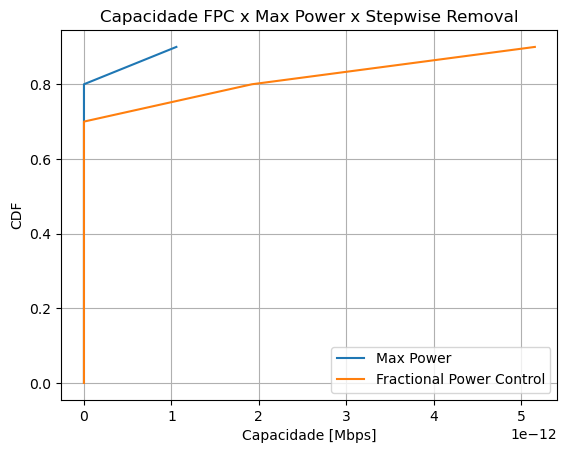

In [14]:
capacityCDF_MP = eCDF(total_capacity_MP)
SINR_CDF_MP = eCDF(total_SINR_MP)
SNR_CDF_MP = eCDF(total_SNR_MP)

capacityCDF_FPC = eCDF(total_capacity_FPC)
SINR_CDF_FPC = eCDF(total_SINR_FPC)
SNR_CDF_FPC = eCDF(total_SNR_FPC)

# capacityCDF_SR = eCDF(total_capacity_SR)
# SINR_CDF_SR = eCDF(total_SINR_SR)
# SNR_CDF_SR = eCDF(total_SNR_SR)


plt.title('Capacidade FPC x Max Power x Stepwise Removal')
plt.xlabel('Capacidade [Mbps]')
plt.ylabel('CDF')

# plt.ylim(0.0, 1.0)
# plt.xlim(-1, 750)
plt.plot(capacityCDF_MP[0], capacityCDF_MP[1], label = 'Max Power')
plt.plot(capacityCDF_FPC[0], capacityCDF_FPC[1], label = 'Fractional Power Control')
#plt.plot(capacityCDF_SR[0], capacityCDF_SR[1], label = 'Stepwise Removal')
plt.legend()
plt.grid()

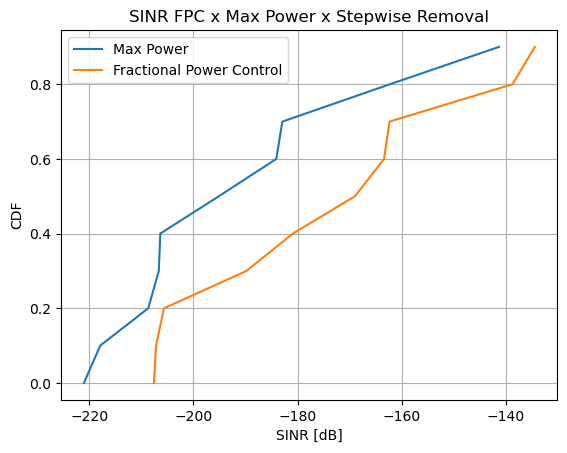

In [15]:
plt.title('SINR FPC x Max Power x Stepwise Removal')
plt.xlabel('SINR [dB]')
plt.ylabel('CDF')

# plt.ylim(0.0, 1.0)
# plt.xlim(-1, 750)
plt.plot(SINR_CDF_MP[0], SINR_CDF_MP[1], label = 'Max Power')
plt.plot(SINR_CDF_FPC[0], SINR_CDF_FPC[1], label = 'Fractional Power Control')
# plt.plot(SINR_CDF_SR[0], SINR_CDF_SR[1], label = 'Stepwise Removal')
plt.legend()
plt.grid()

In [16]:
# spectral_efficiencyCDF = eCDF(b_t*total_spectral_efficiency)
# SINR_CDF = eCDF(total_SINR)
# SNR_CDF = eCDF(total_SNR)

# spectral_efficiencyCDF_ = eCDF(b_t*total_spectral_efficiency_)
# SINR_CDF_ = eCDF(total_SINR_)
# SNR_CDF_ = eCDF(total_SNR_)

# plt.title('Capacidade FPC x Max power')
# plt.xlabel('Capacidade de canal [Mbps]')
# plt.ylabel('CDF')

# # plt.ylim(0.0, 1.0)
# plt.xlim(-10,500)
# plt.plot(spectral_efficiencyCDF[0]/1e6, spectral_efficiencyCDF[1], label = 'Max Power')
# plt.plot(spectral_efficiencyCDF_[0]/1e6, spectral_efficiencyCDF_[1], label = 'Fractional Power Control')
# plt.legend()
# plt.grid()